In [1]:
! pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kazanova/sentiment140

 93% 75.0M/80.9M [00:00<00:00, 111MB/s]
100% 80.9M/80.9M [00:00<00:00, 96.9MB/s]


In [7]:
!unzip sentiment140.zip -d data/

Archive:  sentiment140.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


In [1]:
import pandas as pd

column_names = ['target','id','date','flag','user','text']
twitter_data = pd.read_csv('/content/data/training.1600000.processed.noemoticon.csv',names = column_names, encoding = 'ISO-8859-1')
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [2]:
columns_to_drop = ["id", "date", "flag", "user"]

twitter_data = twitter_data.drop(columns_to_drop, axis=1)

In [3]:
twitter_data = twitter_data.sample(100000, random_state=42, ignore_index=True)
twitter_data

,target,text
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,"@misstoriblack cool , i have no tweet apps fo..."
2,0,@TiannaChaos i know just family drama. its la...
3,0,School email won't open and I have geography ...
4,0,upper airways problem
...,...,...
99995,0,finallytryingto download evernote on my bberry...
99996,0,@kimberly625 @amylovesoliver too late. gues...
99997,4,On the way to target with mah sistaaa
99998,0,"Hip is worse today, moving my leg causes pain...."


In [4]:
twitter_data["target"] = twitter_data["target"].replace(4, 1)

In [7]:
twitter_data["target"].value_counts()

1    50057
0    49943
Name: target, dtype: int64

In [8]:
!pip install -U -q datasets
!pip install -q torchtext
!pip install -U pyarrow

In [9]:
!pip uninstall pyarrow
!pip install pyarrow

Found existing installation: pyarrow 15.0.0
Uninstalling pyarrow-15.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pyarrow-15.0.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pyarrow/*
Proceed (Y/n)? y
  Successfully uninstalled pyarrow-15.0.0
  Using cached pyarrow-15.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (38.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [10]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchtext
from tqdm.auto import tqdm

In [11]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [12]:
dataset = datasets.Dataset.from_pandas(twitter_data)
dataset

Dataset({
    features: ['target', 'text'],
    num_rows: 100000
})

In [13]:
test_size = 0.3

train_test_data = dataset.train_test_split(test_size=test_size)
train_data = train_test_data["train"]
test_data = train_test_data["test"]

In [14]:
valid_size = 0.4 # of test size

test_valid_data = test_data.train_test_split(test_size=valid_size)
test_data = test_valid_data["train"]
valid_data = test_valid_data["test"]

In [15]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [16]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [17]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
valid_data = valid_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [18]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens
)

In [19]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

In [20]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [21]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [22]:
train_data = train_data.with_format(type="torch", columns=["ids", "target", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "target", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "target", "length"])

In [23]:
train_data[3]

{'target': tensor(0),
 'length': tensor(9),
 'ids': tensor([  13,   17, 7992,    8, 4289, 6534,   15,   32,  128])}

In [24]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["target"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}

        return batch
    return collate_fn

In [25]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [26]:
batch_size = 64

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [27]:
class LSTMModel(nn.Module):
    def __init__(
            self,
            vocab_size,
            embedding_dim,
            hidden_dim,
            output_size,
            n_layers,
            bidirectional,
            dropout_rate,
            pad_index
            ):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch_size, seq_len]
        # length = [batch_size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch_size, seq_len, embedding_dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n_layers * n_directions, batch_size, hidden_dim]
        # cell = [n_layers * n_directions, batch_size, hidden_dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch_size, seq_len, hidden_dim*n_directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2 ]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch_size, output_dim]
        return prediction

In [28]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("target"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTMModel(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,267,002 trainable parameters


In [30]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [31]:
model.apply(initialize_weights)

LSTMModel(
  (embedding): Embedding(8854, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [32]:
vectors = torchtext.vocab.GloVe("6B")

In [33]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [34]:
model.embedding.weight.data = pretrained_embedding

In [35]:
lr = 5e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [37]:
model = model.to(device)
loss_fn = loss_fn.to(device)

In [38]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [39]:
for batch in train_data_loader:
    print(batch)
    break

{'ids': tensor([[   0, 8555,   68,  ...,    1,    1,    1],
        [  61,   17, 7445,  ...,    1,    1,    1],
        [  96,    8,    3,  ...,    1,    1,    1],
        ...,
        [   0,  326,   41,  ...,    1,    1,    1],
        [  28,  398,    0,  ...,    1,    1,    1],
        [   0,    3,    5,  ...,    1,    1,    1]]), 'length': tensor([ 6, 19, 16,  5, 18, 28,  7, 12, 12,  9,  6, 16, 16, 26, 13, 34,  7,  7,
        13, 19,  6, 12, 14, 10, 32, 17, 10, 31, 22, 15,  5, 26, 13,  6, 11, 12,
        13, 28, 17,  7,  7, 14, 28,  5,  7, 14, 20, 12, 23, 22, 14, 20, 14, 29,
        26, 31, 26,  6,  6, 17, 30, 11, 15, 21]), 'label': tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1])}


In [40]:
def train(dataloader, model, loss_fn, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = loss_fn(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [41]:
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = loss_fn(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [42]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, loss_fn, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, loss_fn, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.517, train_acc: 0.740
valid_loss: 0.450, valid_acc: 0.786


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.449, train_acc: 0.789
valid_loss: 0.431, valid_acc: 0.798


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.414, train_acc: 0.810
valid_loss: 0.448, valid_acc: 0.801


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.390, train_acc: 0.823
valid_loss: 0.421, valid_acc: 0.806


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.370, train_acc: 0.834
valid_loss: 0.427, valid_acc: 0.808


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.351, train_acc: 0.845
valid_loss: 0.443, valid_acc: 0.800


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.333, train_acc: 0.853
valid_loss: 0.439, valid_acc: 0.805


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.314, train_acc: 0.863
valid_loss: 0.445, valid_acc: 0.804


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 8
train_loss: 0.294, train_acc: 0.873
valid_loss: 0.451, valid_acc: 0.800


training...:   0%|          | 0/1094 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/188 [00:00<?, ?it/s]

epoch: 9
train_loss: 0.275, train_acc: 0.882
valid_loss: 0.491, valid_acc: 0.799


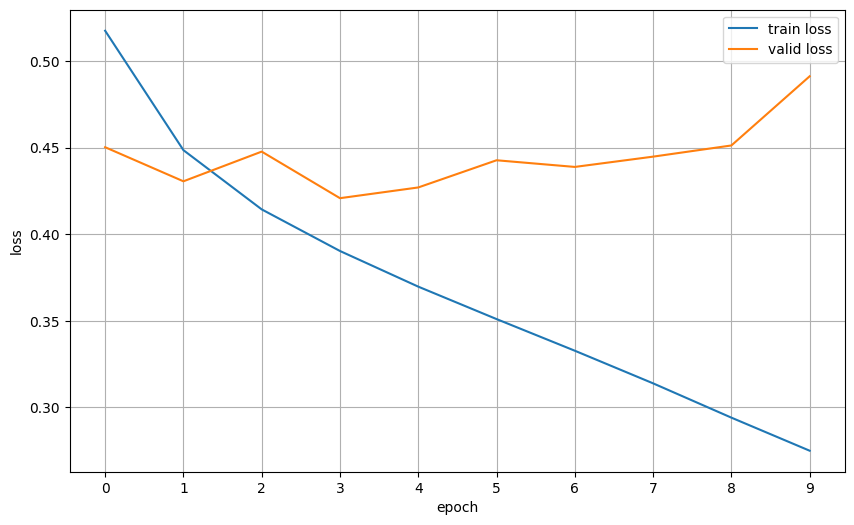

In [44]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

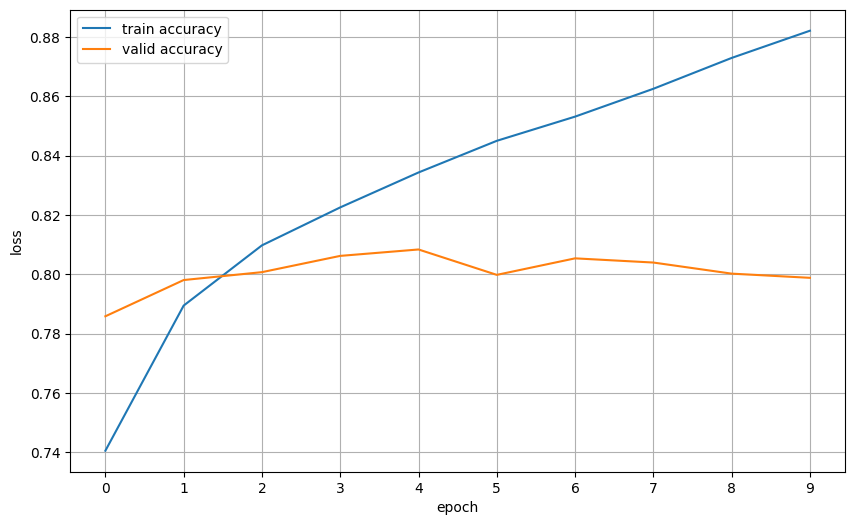

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [46]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, loss_fn, device)

evaluating...:   0%|          | 0/282 [00:00<?, ?it/s]

In [47]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [50]:
text = "This film is great, it's the best i've watched in a while!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9771296381950378)

In [53]:
text = "It isn't actually amusing"
predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.6678659319877625)

In [58]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/lstm_models/sentiment_lstm.pt")